In [ ]:
%pip install -qU scikit-learn torchmetrics transformers

In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
import time
import os
from argparse import Namespace
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import SGD, Adam, AdamW
from transformers import AutoModel, AutoTokenizer
from torchmetrics import Accuracy
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm


In [3]:
work_dir = "./THUCNews"
max_seq_length = 256

In [ ]:
info = pd.read_csv('./THUCNews/Train.txt', sep='\t', header=None, names=['label_id', 'label', 'text'], skip_blank_lines=True)
info.drop_duplicates(subset=['text'], inplace=True)
info.dropna(axis=0, subset=['text'], inplace=True)

label_ids, labels, texts = info.iloc[:, 0], info.iloc[:, 1], info.iloc[:, 2]

split = StratifiedShuffleSplit(test_size=0.05)

train_idx, valid_idx = next(split.split(texts, label_ids))

info_tr = info.iloc[train_idx, :]
info_va = info.iloc[valid_idx, :]

info_tr.to_csv(f"{work_dir}/train.csv", header=False, index=False)
info_va.to_csv(f"{work_dir}/valid.csv", header=False, index=False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(
    "silk-road/luotuo-bert",
    trust_remote_code=True, 
)

luotuo = AutoModel.from_pretrained(
    "silk-road/luotuo-bert",     
    trust_remote_code=True,
    model_args=Namespace(do_mlm=None, pooler_type="cls", temp=0.05, mlp_only_train=False, init_embeddings_model=None)
).to(device)

In [5]:
class Data(Dataset):
    def __init__(self, root, mode):
        super(Dataset, self).__init__()
        self.mode = mode

        if mode == 'Train':
            info = pd.read_csv(f"{root}/train.csv", header=None)
            self.text = info.iloc[:, 2].to_list()
            self.labels = torch.as_tensor(info.iloc[:, 0].to_list())
        elif mode == 'Valid':
            info = pd.read_csv(f"{root}/valid.csv", header=None)
            self.text = info.iloc[:, 2].to_list()
            self.labels = torch.as_tensor(info.iloc[:, 0].to_list())
        elif mode == 'Test':
            info = pd.read_csv(f"{root}/Test.txt", sep='\t', header=None)
            self.text = info.iloc[:, 0].to_list()
            self.labels = None    
        else:
            pass

    def __getitem__(self, idx):
        data = {"text": self.text[idx]}
        if self.mode != 'Test':
            data['label'] = self.labels[idx]
        else:
            data['label'] = -1
        return data

    def __len__(self):
        return len(self.text)

In [6]:
train_batchify_fn = lambda samples: (
    tokenizer([sample['text'] for sample in samples], padding=True, truncation=True, return_tensors="pt"),
    torch.tensor([sample['label'] for sample in samples], dtype=torch.long)
)

In [9]:
train_set = Data('./THUCNews', 'Train')
valid_set = Data('./THUCNews', 'Valid')

load_train = DataLoader(
    train_set, 
    batch_size=128, 
    shuffle=True, 
    collate_fn=train_batchify_fn
)

load_train = [(token.to(device), label.to(device)) for token, label in tqdm(load_train)]

load_valid = DataLoader(
    valid_set, 
    batch_size=128, 
    shuffle=False,  
    collate_fn=train_batchify_fn
)

load_valid = [(token.to(device), label.to(device)) for token, label in tqdm(load_valid)]

100%|██████████| 292/292 [00:01<00:00, 205.46it/s]


In [31]:
class Classif(nn.Module):
    def __init__(self, num_classes):
        super(Classif, self).__init__()
        self.dense = nn.Linear(1536, 1024)
        self.fc = nn.Linear(1024, 768)
        self.dropout = nn.Dropout(p=0.1)
        self.out_proj = nn.Linear(768, num_classes)
    def forward(self, pooled_output):
        x = self.dense(pooled_output)
        x = self.fc(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class BertClassifier(nn.Module):
    def __init__(self, bert_model, num_classes=1):
        super(BertClassifier, self).__init__()
        self.bert_model = bert_model
        self.classifier = Classif(num_classes)

    def forward(self, **token):
        outputs = self.bert_model(**token, output_hidden_states=True, return_dict=True, sent_emb=True)
        pooled_output = outputs.pooler_output
        hidden_states = outputs.last_hidden_state
        logits = self.classifier(pooled_output)
        return logits,hidden_states
    
model = BertClassifier(luotuo, num_classes=14).to(device)

In [42]:
optimizer = Adam(
    model.parameters(),
    lr=1e-5
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    threshold=0.01,
    verbose=True
)

loss_func = nn.CrossEntropyLoss()
accuracy = Accuracy(task="multiclass", num_classes=14).to(device)

In [12]:
from tqdm import tqdm

max_acc = 0

for epoch in range(1):
    t0 = time.time()
    model.train()
    for token, label in load_train:
        optimizer.zero_grad()
        logit,_ = model(**token)
        loss = loss_func(logit, label)
        loss.backward()
        optimizer.step()

    model.eval()
    loss_tr = 0.
    for token, label in load_train:
        logit,_ = model(**token)
        loss_tr += loss_func(logit, label).item()
    loss_tr /= len(load_train)

    loss_va = 0.
    acc_va = 0.
    for token, label in load_valid:
        logit = model(**token)
        loss_va += loss_func(logit, label).item()
        acc_va += accuracy(logit, label)
    loss_va /= len(load_valid)
    acc_va /= len(load_valid)

    scheduler.step(loss_va)
  
    t = time.time() - t0
    print('[Epoch {:3d} {:.2f}s] train loss({:.4f}); valid loss({:.4f}), acc({:.2f})'
            .format(epoch, t, loss_tr, loss_va, acc_va))
  
    if(acc_va >= max_acc):
        torch.save(model.state_dict(), f"./THUCNews/model.save")


In [13]:
torch.save(model.state_dict(), f"./THUCNews/luotuo_model_latest")

In [ ]:
import json

test_set = Data('./THUCNews', mode='Test')
load_test = DataLoader(
    test_set, 
    batch_size=128, 
    shuffle=False,  
    collate_fn=train_batchify_fn
)

load_test = [(token.to(device), label.to(device)) for token, label in tqdm(load_test)]

test_pred = []
with torch.no_grad():
    for token, label in load_test:
        logit,_ = model(**token)
        print(logit)
        pred = torch.argmax(
            F.softmax(logit),
            axis=-1
        )
        test_pred.append(pred.cpu().numpy())
test_pred = np.concatenate(test_pred, axis=0) 

label_dict = {}

with open("THUCNews/label_dict.json") as labels:
    label_dict = json.load(labels)

with open("result.txt", 'w') as output:
    for text, pred in zip(test_set.text, test_pred.astype(int)):
        pred_class = label_dict[str(pred)]
        output.writelines(f"{pred_class}\n")

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(
    "silk-road/luotuo-bert",
    trust_remote_code=True, 
)
luotuo = AutoModel.from_pretrained(
    "silk-road/luotuo-bert",     
    trust_remote_code=True,
    model_args=Namespace(do_mlm=None, pooler_type="cls", temp=0.05, mlp_only_train=False, init_embeddings_model=None)
    
).to(device)
model_state_dict = torch.load('./THUCNews/luotuo_model_latest.bin', map_location=torch.device('cpu'))
model = BertClassifier(luotuo, num_classes=14).to(device)
model.load_state_dict(model_state_dict,strict=False)

<All keys matched successfully>

100%|██████████| 200/200 [00:00<00:00, 3781.97it/s]
C:\Users\Constantine\AppData\Local\Temp\ipykernel_14984\2786819768.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(logit),


19
19
20
20
23
22
21
25
19
20
21
21
20
19
24
15
17
19
18
14
23
19
23
23
22
24
19
17
19
17
23
11
20
13
18
19
23
23
24
18
21
22
19
14
24
25
14
19
17
22
21
24
24
17
14
24
23
22
16
18
19
17
18
17
22
12
24
17
19
19
24
24
20
19
16
16
19
17
24
21
20
22
18
24
18
21
26
20
17
18
24
23
26
24
16
23
17
24
16
19
24
14
20
12
20
18
18
20
24
19
12
17
20
16
24
23
20
18
24
19
18
24
20
20
20
18
25
19
15
18
25
18
19
24
22
24
16
19
18
19
19
22
20
21
16
15
23
17
20
24
19
20
23
25
18
17
25
20
23
14
15
24
18
24
17
12
19
19
25
20
19
23
20
21
25
17
26
22
14
19
20
19
14
25
14
18
22
20
16
23
19
19
24
14
20
16
23
25
23
14


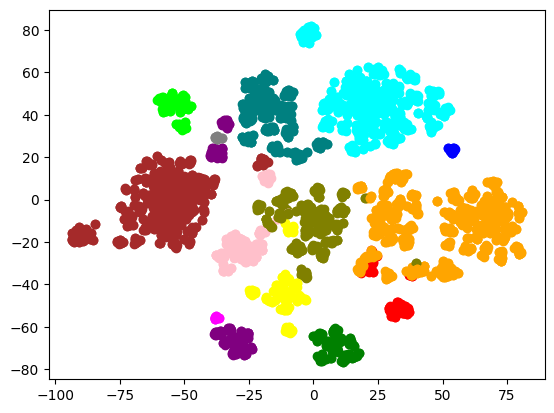

In [54]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

test_set = Data('./THUCNews', mode='Test')
load_test = DataLoader(
    test_set, 
    batch_size=1, 
    shuffle=False,  
    collate_fn=train_batchify_fn
)

load_test = [(token.to(device), label.to(device)) for token, label in tqdm(load_test)]

# fig,axs = plt.subplots(1,1,figsize = (16,8))

for plt_id in range(1):
    plt_id

    points = []
    cols = []

    with torch.no_grad():
        for token, label in load_test:
            logit,all_hidden_states = model(**token)
            pred = torch.argmax(
                F.softmax(logit),
                axis=-1
            )
            sentence_embedding = torch.mean(all_hidden_states,dim = 0)
            points.append(sentence_embedding.cpu().detach().numpy())
            for i in range(len(sentence_embedding)):
                cols.append(pred.cpu().numpy())

    points = np.concatenate(points, axis=0)
    cols = np.concatenate(cols,axis=0)
    # print(len(cols))
    # print(cols)

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'lime', 'teal']

    tsne = TSNE(n_components=2, random_state=42)
    tsne_vectors = tsne.fit_transform(points)

    for point,col in zip(tsne_vectors,cols.astype(int)):
        plt.scatter(point[0], point[1],c = colors[col])
    
plt.show()